In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Constants
DATA_DIRECTORY = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 2.4926 Acc: 0.1294
validation Loss: 2.2904 Acc: 0.1940
Epoch 2/10
----------
train Loss: 2.2309 Acc: 0.2111
validation Loss: 1.8767 Acc: 0.3403
Epoch 3/10
----------
train Loss: 1.8720 Acc: 0.3454
validation Loss: 1.5736 Acc: 0.4193
Epoch 4/10
----------
train Loss: 1.6067 Acc: 0.4406
validation Loss: 1.3170 Acc: 0.5530
Epoch 5/10
----------
train Loss: 1.4249 Acc: 0.5055
validation Loss: 1.1848 Acc: 0.6047
Epoch 6/10
----------
train Loss: 1.2852 Acc: 0.5627
validation Loss: 0.9934 Acc: 0.6780
Epoch 7/10
----------
train Loss: 1.1070 Acc: 0.6279
validation Loss: 1.0447 Acc: 0.6420
Epoch 8/10
----------
train Loss: 1.0364 Acc: 0.6615
validation Loss: 0.6427 Acc: 0.7797
Epoch 9/10
----------
train Loss: 0.9517 Acc: 0.6904
validation Loss: 0.7529 Acc: 0.7807
Epoch 10/10
----------
train Loss: 0.8187 Acc: 0.7358
validation Loss: 0.5369 Acc: 0.8260
Best validation Acc: 0.826000


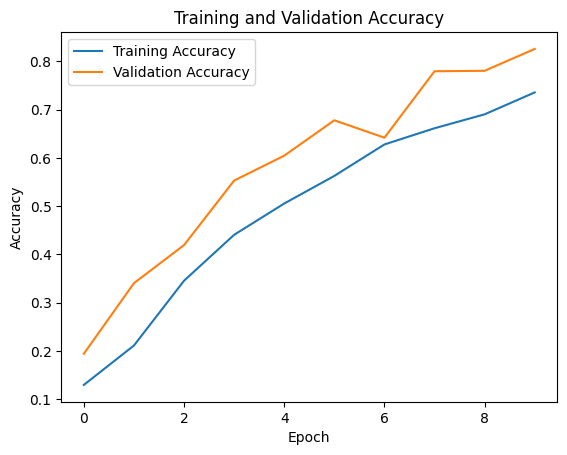

Test Accuracy: 0.8383
Precision: 0.8592
Recall: 0.8383
F1 Score: 0.8374
Mean Loss: 0.5099
              precision    recall  f1-score   support

        Bean       0.79      0.94      0.86       200
Bitter_Gourd       0.81      0.91      0.85       200
Bottle_Gourd       0.99      0.83      0.90       200
     Brinjal       0.84      0.79      0.82       200
    Broccoli       0.98      0.93      0.95       200
     Cabbage       0.97      0.76      0.85       200
    Capsicum       0.72      0.96      0.83       200
      Carrot       0.85      0.96      0.90       200
 Cauliflower       0.70      0.91      0.79       200
    Cucumber       0.70      0.92      0.79       200
      Papaya       0.98      0.59      0.74       200
      Potato       0.94      0.71      0.81       200
     Pumpkin       0.81      0.92      0.86       200
      Radish       0.94      0.68      0.78       200
      Tomato       0.88      0.78      0.83       200

    accuracy                           0.84 

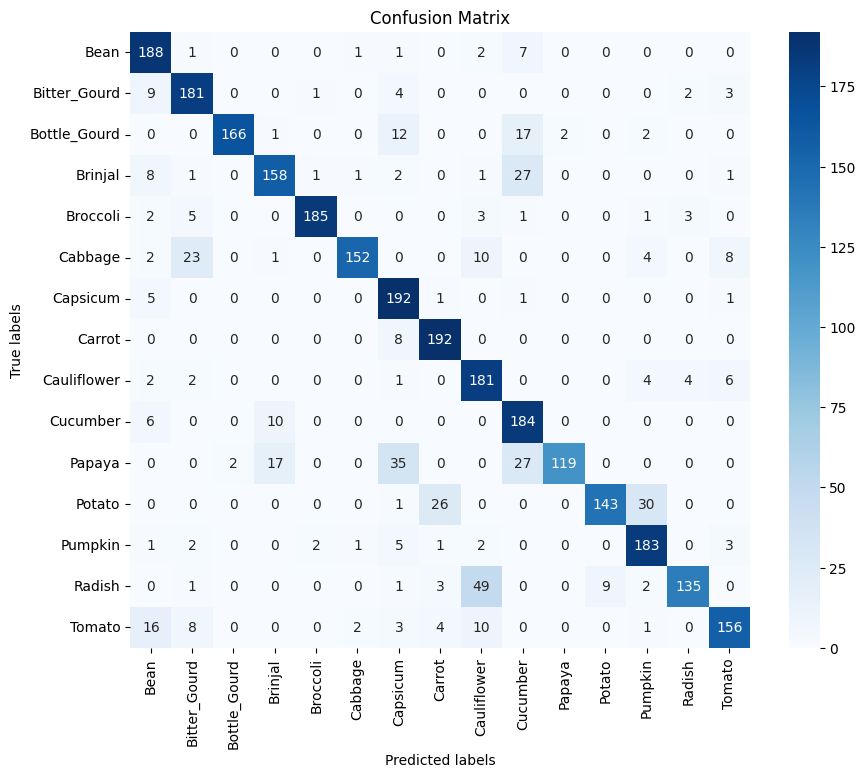

In [ ]:
# Constants
BATCH_SIZE = 64
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.vgg16(pretrained=False)
    for param in model.parameters():
        param.requires_grad = True
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)
    )
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        if val_acc_history[-1] > best_acc:
            best_acc = val_acc_history[-1]

    print('Best validation Acc: {:4f}'.format(best_acc))

    plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    print(classification_report(y_true, y_pred, target_names=image_datasets['test'].classes))

    return y_true, y_pred

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_model(model, criterion, optimizer, num_epochs=10)

y_true, y_pred = evaluate_model(model, dataloaders['test'])

conf_matrix = confusion_matrix(y_true, y_pred)
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)